In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


371 128 96 78 327


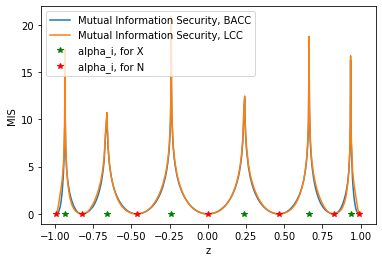

-0.9904231284161811 0.002545988916433775
-0.9840348954471423 0.04568003220792001
-0.9819451588330403 0.07563641161113017
-0.9810861386834353 0.0908592108947527
-0.9773599210161321 0.1801797307937816
-0.9666355668346698 0.7354190442336326
-0.9622589171126521 1.1365473047906514
-0.9613183850556295 1.2389602118079723
-0.9599456749886062 1.399564909478382
-0.9590180134967923 1.5158887581506482
-0.9575891080038901 1.7079852371845186
-0.9561936585770487 1.9115739891980268
-0.9543679699143783 2.2037704659742126
-0.951463187769173 2.737506936512943
-0.949455388077479 3.1657029088817357
-0.9469672329851415 3.7834948509544737
-0.94502274430461 4.356284407748436
-0.9407530777561179 6.101814274120889
-0.9380888764015067 7.993337972566525
-0.9371679572108156 9.05245721134913
-0.93714936164548 9.078129969539567
-0.9351596835849159 16.93395976759343
-0.934868399697222 16.85648390663707
-0.933553528402197 10.287181768295074
-0.93230483506727 8.547438326014959
-0.9306512159656071 7.2270353504721925
-0.

0.953671633298314 2.3235529424344445
0.9540220323398028 2.262675012729333
0.9555601310592956 2.0095231125905384
0.955770805950217 1.976555626669604
0.9559148077806445 1.954249262940429
0.9571384738708655 1.7719512837632683
0.9571808277801219 1.765868206077496
0.9588791122489926 1.5338643919601298
0.9597707640836168 1.4210076469955135
0.9640733275759785 0.9556670033653697
0.9650764497558149 0.8646953202858207
0.9696555294397105 0.5241217654653044
0.9717879105521774 0.4032312395715541
0.9807165001791225 0.0979778037643968
0.9827457044466505 0.06302717455442429
0.9874649190325822 0.014827638685087739
0.9878798443126815 0.012395802186275
0.9898030700720033 0.004202379372326719
0.993669753144766 0.00040337006600140894
0.9966678036813599 0.006203579257266869
0.9997876469590101 0.01794094489732098


In [3]:
K = 6
T = 7
Noise_Alloc = [0,2,4,6,8,10,12]
sigma = 1

N = 12

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [41]:
z_array_ = np.array([-0.9702, -0.8668, -0.765, -0.538, -0.383, -0.087, 0.087,0.383, 0.538, 0.765,0.8668, 0.9702])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.49114422 0.49586111 0.49792726 0.48895618 0.49606435 0.4897194
 0.4897194  0.49606435 0.48895618 0.49792726 0.49586111 0.49114422]


In [67]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 6
T = 7
sigma = 1
Noise_Alloc = [0,2,4,6,8,10,12]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [12]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K6_G1_N12 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K6_G1_N12  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)

#         if N==2:
#             z_array = np.array([-0.81, 0.81])
#         elif N ==4:
#             z_array = np.array([-0.81, -0.22, 0.22, 0.81])
#         elif N ==5:
#             z_array = np.array([-0.81, -0.22, 0, 0.22, 0.81])
#         elif N ==6:
#             z_array = np.array([-0.9, -0.81, -0.22, 0.22, 0.81, 0.9])
#         elif N ==7:
#             z_array = np.array([-0.9, -0.82, -0.21, 0, 0.21, 0.82, 0.9])
#         else:
#             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
        
        z_array = np.array([-0.9702, -0.8668, -0.765, -0.538, -0.383, -0.087, 0.087,0.383, 0.538, 0.765,0.8668, 0.9702])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K6_G1_N12[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K6_G1_N12[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.9702 -0.8668 -0.765  -0.538  -0.383  -0.087   0.087   0.383   0.538
  0.765   0.8668  0.9702]
0.49114422108359246
0.49586111464393723
0.497927255191399
0.48895617904704053
0.4960643470070548
0.4897194008225054
0.48971940082250653
0.496064347007058
0.48895617904703803
0.4979272551914008
0.49586111464393606
0.49114422108359496
@BACC_Enc: N,K,T, m_i= 12 6 7 10000 

@BACC_Enc: N,K,T, m_i= 12 6 7 10000 

(T, sigma)= 7 1 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.01323641300201416
conv1.bias 0.013256067410111427
conv2.weight 0.0004138882085680962
conv2.bias 0.00042953575029969215
fc1.weight 0.0003273265436291695
fc1.bias 0.0002773181302472949

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.00034409161657094955
conv1.bias 0.0016372406389564276
conv2.weight 0.00025343535467982293
conv2.bias 0.000410629669204


Test set: Average loss: 2.3000 
Accuracy: 1135/10000 (11.35%)

Round  21, Average loss 2.300 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.0004574401676654816
conv1.bias 0.0008982212166301906
conv2.weight 0.0001188450213521719
conv2.bias 0.0009229113929904997
fc1.weight 0.00019578519277274609
fc1.bias 0.0010612521320581437

Test set: Average loss: 2.2839 
Accuracy: 4388/10000 (43.88%)

Round  22, Average loss 2.284 Test accuracy 43.880
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.00023281209170818328
conv1.bias 0.0009403058793395758
conv2.weight 8.460357785224914e-05
conv2.bias 0.0008191067026928067
fc1.weight 0.0001277804607525468
fc1.bias 0.0002895451383665204

Test set: Average loss: 2.2642 
Accuracy: 3799/10000 (37.99%)

Round  23, Average loss 2.264 Test accuracy 37.990
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.0002692745253443718
conv1.bias 0.0010231141932308674
conv2.weight 0.00017482

# 5.2. K=6, G=2, N=12 => K_i =3, N_i = 6

375 127 93 68 337


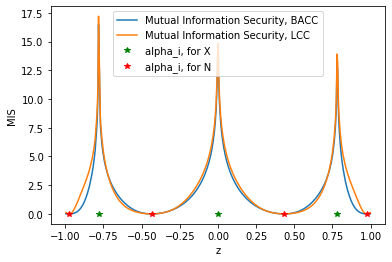

-0.9969063956393398 0.015869569238180458
-0.9961416754051027 0.014892130787111721
-0.9926851674365291 0.010784286346841575
-0.9914032438759146 0.009398276579128426
-0.9888154896697541 0.006846381442283329
-0.987876295586551 0.006005994512303329
-0.983205407253134 0.0025685986948604128
-0.9831510552533835 0.002536325610539046
-0.9804722783365587 0.0011837125623086076
-0.9801849720343394 0.0010672252087882612
-0.9795494731437013 0.000829976621831478
-0.9791880718765633 0.0007077626036794876
-0.9764263126787542 8.998126532036522e-05
-0.9749813192461096 1.1596415842975012e-07
-0.9738791291661815 4.521272836513751e-05
-0.9736219755573623 7.028234480248774e-05
-0.9729443323458871 0.00016324343660581808
-0.9727816392135311 0.00019143056204626123
-0.9727185897453103 0.00020297046010390017
-0.9711114777244578 0.0006154681710042074
-0.9699200521878515 0.0010724509639323757
-0.966436593388476 0.0031932497187404044
-0.9645987330763623 0.004813597868895938
-0.9628023946383752 0.006755095933982157
-

In [43]:
K = 3
T = 4
Noise_Alloc = [0,2,4,6]
sigma = 1

N = 6

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [54]:
z_array_ = np.array([-0.900, -0.568, -0.2749, 0.2749,0.568, 0.900])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.48415855 0.49029931 0.49299416 0.49299416 0.49029931 0.48415855]


## 5.2. G=2, K=6, N= 12

In [68]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 12
K = 6
G = 2

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 6
K_i = int(K/G) # = 4
T = 4
sigma = 1
Noise_Alloc = [0,2,4,6]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.900, -0.568, -0.2749, 0.2749,0.568, 0.900])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K6_G2_N12 = np.zeros((N_trials,N_epochs))
acc_test_arr_K6_G2_N12  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K6_G2_N12[trial_idx][iter] = acc_test
        loss_test_arr_K6_G2_N12[trial_idx][iter] = loss_test

        
        
    

6 3 4
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

selected users: [0 1 2 3 4 5]
conv1.weight 0.013702858686447144
conv1.bias 0.015688138082623482
conv2.weight 0.0004159551113843918
conv2.bias 0.00042428955202922225
fc1.weight 0.0003288311883807182
fc1.bias 0.00020257248543202876
selected users: [0 1 2 3 4 5]
conv1.weight 0.013702858686447144
conv1.bias 0.015688138082623482
conv2.weight 0.0004159551113843918
conv2.bias 0.00042428955202922225
fc1.weight 0.0003288311883807182
fc1.bias 0.00020257248543202876

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3 4 5]
conv1.weight 0.0003865440934896469
conv1.bias 0.0021470850333571434
conv2.weight 0.00032876696437597277
conv2.bias 0.0004986294079571962
fc1.weight 5.331346183083952e-05
fc1.bias 0.00035845807287842034
selected users: 

selected users: [0 1 2 3 4 5]
conv1.weight 0.00038215160369873044
conv1.bias 0.0019353986717760563
conv2.weight 5.274959839880466e-05
conv2.bias 0.0008199538569897413
fc1.weight 0.00015148677630349994
fc1.bias 0.0004361219238489866

Test set: Average loss: 2.2984 
Accuracy: 1580/10000 (15.80%)

selected users: [0 1 2 3 4 5]
conv1.weight 0.0002943524159491062
conv1.bias 0.0011667776852846146
conv2.weight 0.00012882144190371037
conv2.bias 0.0012687313137575984
fc1.weight 9.160954505205154e-05
fc1.bias 0.0005032386165112257
selected users: [0 1 2 3 4 5]
conv1.weight 0.0002943524159491062
conv1.bias 0.0011667776852846146
conv2.weight 0.00012882144190371037
conv2.bias 0.0012687313137575984
fc1.weight 9.160954505205154e-05
fc1.bias 0.0005032386165112257

Test set: Average loss: 2.2736 
Accuracy: 3605/10000 (36.05%)

selected users: [0 1 2 3 4 5]
conv1.weight 0.0003749251365661621
conv1.bias 0.0012964544584974647
conv2.weight 6.586589384824037e-05
conv2.bias 0.0008589040953665972
fc1.weight 0

## 5.3. G=3, K=6, N=12

In [69]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 12
K = 6
G = 3

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 6
K_i = int(K/G) # = 4
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K6_G3_N12 = np.zeros((N_trials,N_epochs))
acc_test_arr_K6_G3_N12  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K6_G3_N12[trial_idx][iter] = acc_test
        loss_test_arr_K6_G3_N12[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80

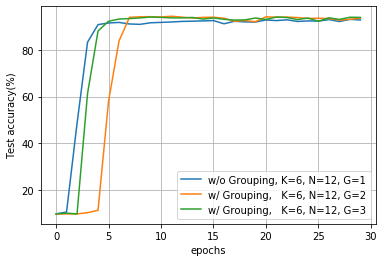

In [62]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K6_G1_N12[0,0,0,0:30],label='w/o Grouping, K=6, N=12, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K6_G2_N12[0,0:30],label='w/ Grouping,   K=6, N=12, G=2')
plt.plot(acc_test_arr_K6_G3_N12[0,0:30],label='w/ Grouping,   K=6, N=12, G=3')
# plt.plot(acc_test_arr_K4_G4_N8[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()